In [12]:
using JuMP, Mosek
function pickOpt(sub_test_image,optimize_color)
    m = Model(solver = MosekSolver(LOG=1))
    @variable(m, pick_basis[1:n_basis], Bin)
    @variable(m, AbsMatchError[1:n_colors] >= 0)
        
    @constraint(m, sum(pick_basis) == 1)
        
    test_image_value = nothing
    if optimize_color
        test_image_value = [ mode(sub_test_image[:,:,color]) for color in 1:n_colors ]
    else
        test_image_value = [ mean(sub_test_image[:,:,color]) for color in 1:n_colors ]
    end
        
    @expression(m, MatchError[color in 1:n_colors], test_image_value[color] - sum(dot(pick_basis,basis_colors[:,color])) )
    @constraint(m, MatchError .<=  AbsMatchError)
    @constraint(m, MatchError .>= -AbsMatchError)
        
    @objective(m, Min, sum(AbsMatchError))
        
    status = solve(m)
    # show some output to communicate that things are moving forward
    opt_pick_basis = getvalue(pick_basis)
    chosen_basis = findfirst(opt_pick_basis)
    
    return chosen_basis
end

; # to suppress output

In [13]:
#*******************************************#
# HINT: CHOOSE ONE OF THE TEST IMAGES BELOW #
#*******************************************#

test_image = test_images_mat[1] # qr code
# test_image = test_images_mat[2] # dog
# test_image = test_images_mat[3] # frog
# test_image = test_images_mat[4] # iron man
# test_image = test_images_mat[5] # wisconsin state capitol

#******************************************#
# HINT: CHOOSE ONE OF THE BASIS SETS BELOW #
#******************************************#

image_files = get_image_files("./grayscale")
# image_files = get_image_files("./music0500")
# image_files = get_image_files("./music1000")
# image_files = get_image_files("./music1500")
# image_files = get_image_files("./small_set")
# image_files = get_image_files("./small_set_2")
# image_files = get_image_files("./avengers")

#**************************************#
# HINT: TRY PLAYING WITH THIS SETTING! #
#**************************************#
# set desired size and rescale the basis images
#    e.g. setting 16 here will result in a 16x16 basis image
#         and a 16x16 grid element size
# Do not pick a number that results in a size bigger than
#    the test image iteself
base_size = 8

; # to suppress output

In [17]:
function brute_force(test_image, images_mat, base_size, optimize_color)
    ## compact function that uses the brute force mosaicking, return the assembled image
    ## inputs: test_image, the image we are trying to mosaic in cellarray form
    ##         images_mat, the image library loaded in cellarray form
    ##         base_size, number of pixels along the width of the square base
    ##         optimize_color, logical variable, choose whether we use mean absolute difference (F)
    ##                         or mode absolute difference (T)
    
    # scale the library based on the desired size from input
    desired_size = (base_size, base_size)
    images_mat = scale_cellarray_mats(images_mat, desired_size)
    # get dimensions 
    n_basis = length(images_mat) # number of basis images
    w_basis = size(images_mat[1], 2) # basis width
    h_basis = size(images_mat[1], 1) # basis height
    w_test_image = size(test_image, 2) # target width
    h_test_image = size(test_image, 1) # target height
    n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
    n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height

    # prepare some arrays for storage
    basis_colors = nothing
    n_colors = nothing
    basis_choice = zeros(n_basis_height, n_basis_width)
    mosaic_image = similar(test_image)

    @showprogress 1 for j = 1:n_basis_height # loop over all subimages
        for i = 1:n_basis_width
            # pick out the target grid
            sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
            if optimize_color # use mode absolute difference 
                n_colors = 3
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mode(images_mat[basis][:,:,color])
                    end
                end
            else # use mean absolute difference 
                n_colors = 1
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mean(images_mat[basis][:,:,:])
                    end
                end
            end
            chosen_basis = pickOpt(sub_test_image,optimize_color) # call optimization fucntion for the subimage
            basis_choice[j,i] = chosen_basis
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = images_mat[chosen_basis]
        end
    end
    return mosaic_image
end;


Progress: 100% Time: 0:00:21


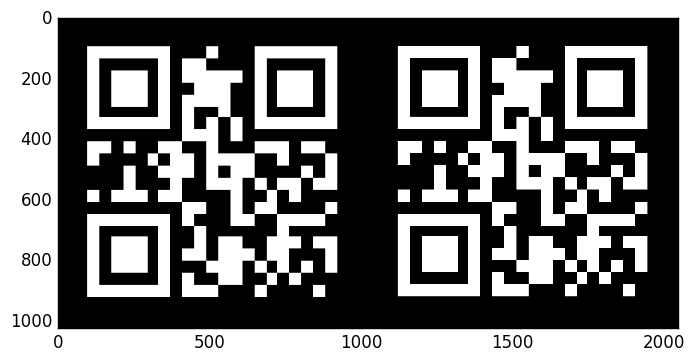

In [18]:
mosaic_image=brute_force(test_image,images_mat,8,true);
imshow([test_image mosaic_image]);

In [20]:
image_files = get_image_files("./music0500")
# load basis images
images_mat = load_images_as_cellarray_mats(image_files)

function split_rgb(test_image, images_mat, base_size, optimize_color)
    ## compact function that uses the splitting rgb speed up, return the assembled image
    ## inputs: test_image, the image we are trying to mosaic in cellarray form
    ##         images_mat, the image library loaded in cellarray form
    ##         base_size, number of pixels along the width of the square base
    ##         optimize_color, logical variable, choose whether we use mean absolute difference (F)
    ##                         or mode absolute difference (T)
    
    # scale the library based on the desired size from input
    desired_size = (base_size, base_size)
    images_mat = scale_cellarray_mats(images_mat, desired_size)
    
    # declare the 3 channels and split the scaled library into 3 channels
    images_r = similar(images_mat)
    images_g = similar(images_mat)
    images_b = similar(images_mat)
    count=split_channel(images_mat,images_r,images_g,images_b)
    images_r = images_r[1:count[1]]
    images_g = images_g[1:count[2]]
    images_b = images_b[1:count[3]]
    
    # get dimensions 
    n_basis = length(images_mat) # number of basis images
    w_basis = size(images_mat[1], 2) # basis width
    h_basis = size(images_mat[1], 1) # basis height
    w_test_image = size(test_image, 2) # target width
    h_test_image = size(test_image, 1) # target height
    n_basis_width = round(Int64, w_test_image/w_basis) # number of basis images needed to fill target width
    n_basis_height = round(Int64, h_test_image/h_basis) # number of basis images needed to fill target height
    
    # prepare some arrays for storage
    basis_colors = nothing
    n_colors = nothing
    basis_choice = zeros(n_basis_height, n_basis_width)
    mosaic_image = similar(test_image)

    @time @showprogress 1 for j = 1:n_basis_height # loop over all sub images
        for i = 1:n_basis_width
            # pick out the target grid
            sub_test_image = test_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ]
            # find the channel of the sub-image and choose the corresponding basis for optimization
            channel = find_channel(sub_test_image)
            if (channel == 1)
                images_base = images_r
            elseif (channel == 2)
                images_base = images_g
            else
                images_base = images_b
            end
            n_basis = size(images_base)[1] # the basis size of the specific channel
            if optimize_color # optimize mean absolute difference
                n_colors = 3
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mode(images_base[basis][:,:,color])
                    end
                end
            else # optimiza mode absolute difference
                n_colors = 1
                basis_colors = zeros(n_basis, n_colors)
                for color in 1:n_colors
                    for basis in 1:n_basis
                        basis_colors[basis,color] = mean(images_base[basis][:,:,:])
                    end
                end
            end
            chosen_basis = pickOpt(sub_test_image,optimize_color)
            basis_choice[j,i] = chosen_basis
            mosaic_image[ (j-1)*h_basis+(1:h_basis) , (i-1)*w_basis+(1:w_basis) , : ] = copy(images_base[chosen_basis])
        end
    end

    return mosaic_image
end;

 in depwarn at deprecated.jl:73
 in to_index at deprecated.jl:447
 in split_channel at In[19]:25
 in split_rgb at In[20]:21
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/Song/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/Song/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[21], in expression starting on line 1
 in depwarn at deprecated.jl:73
 in to_index at deprecated.jl:447
 in split_channel at In[19]:27
 in split_rgb at In[20]:21
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /Users/Song/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /Users/Song/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading In[21], in expression starting on line 1
 in depwarn at deprecated.jl:73
 in to_index at deprecated.jl:447
 in split_channel at In[19]:29
 in split_rgb at In[20]:21
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at

Progress: 100% Time: 0:03:02
181.942823 seconds (358.33 M allocations: 63.209 GB, 5.70% gc time)


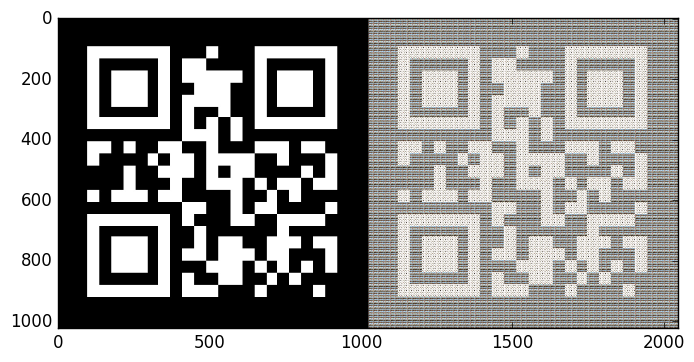

In [21]:
mosaic_image=split_rgb(test_image,images_mat,8,true);
imshow([test_image mosaic_image]);